# OnePiece Character Classification



Рассмотрим датасет по классификации персонажей аниме.

Ссылка: https://www.kaggle.com/t/9c9b62ef8f964ef6ba475708c652a441 Попробуйте обучить сверточную нейронную сеть, используя обучение с нуля или файнтюнинг. Вы можете воспользоваться сторонними библиотеками для вашей работы, но модель и основной код должны быть написаны на pytorch. В этом задании можно использовать любые предобученные модели/готовый код, но будьте готовы объяснять все детали того, как они работают.

- Задание обязательно, базовое максимальное число баллов - 12.
- Топ 25% получат +4 балла, топ 50 +3 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Финальные баллы будут складываться из обработки данных, подготовки датасета, включая аугментации, кода модели, обучения/файнтюна, кода для профайлинга модели, проверки гипотез и управления экспериментами. Если вы попробовали несколько архитектур, это тоже будет учтено.

In [1]:
!unzip -q /content/one-piece-classification-2025.zip -d /content
!mv /content/one-piece-classification-2025/* /content
!rm -r /content/one-piece-classification-2025

mv: cannot stat '/content/one-piece-classification-2025/*': No such file or directory
rm: cannot remove '/content/one-piece-classification-2025': No such file or directory


In [2]:
import glob
import json
import os
import random
import time
import tempfile
from collections import OrderedDict
from typing import Callable, Optional

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

In [3]:
# для воспроизводимости
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## EDA



In [5]:
DATA_DIR = 'splitted'
ANNOTATIONS_PATH = 'train_annotations.csv'
LABELS_PATH = 'labels.json'

ann = pd.read_csv(ANNOTATIONS_PATH)
with open(LABELS_PATH, 'r') as f:
    labels = json.load(f)

ann.head(), labels


(                                     id image_name     class  label  split  \
 0  798fbb1a-6b41-4456-aaec-5529552bc2dd     90.png  Rayleigh     12  train   
 1  3b137c62-fc85-4cd1-a22b-7d715665bd00    198.jpg    Jinbei      6  train   
 2  de9aca01-b137-44b1-a53e-73e0806ecb4f     78.jpg     Sanji     14  train   
 3  affe247e-b769-40dc-8ce8-2ce4e09703d7    192.jpg     Robin     13  train   
 4  ea7238dc-c470-48ca-958b-7c8268e41667     31.png    Mihawk     10  train   
 
               image_path  
 0  train\Rayleigh\90.png  
 1   train\Jinbei\198.jpg  
 2     train\Sanji\78.jpg  
 3    train\Robin\192.jpg  
 4    train\Mihawk\31.png  ,
 {'0': 'Ace',
  '1': 'Akainu',
  '2': 'Brook',
  '3': 'Chopper',
  '4': 'Crocodile',
  '5': 'Franky',
  '6': 'Jinbei',
  '7': 'Kurohige',
  '8': 'Law',
  '9': 'Luffy',
  '10': 'Mihawk',
  '11': 'Nami',
  '12': 'Rayleigh',
  '13': 'Robin',
  '14': 'Sanji',
  '15': 'Shanks',
  '16': 'Usopp',
  '17': 'Zoro'})

In [6]:
print(f"Общее число примеров: {len(ann)}")
print(f"Число уникальных id: {ann['id'].nunique()}")
print(f"Число классов: {len(labels)}")

Общее число примеров: 2916
Число уникальных id: 2916
Число классов: 18


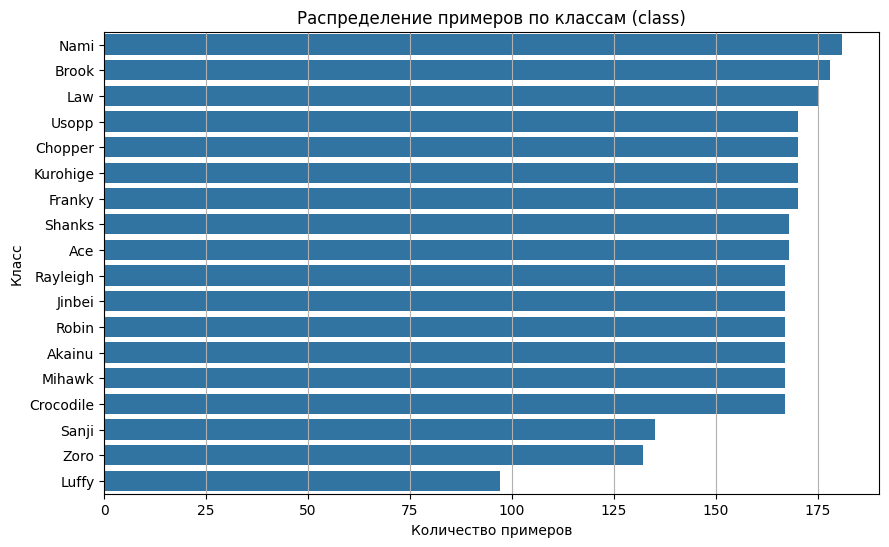

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y=ann['class'], order=ann['class'].value_counts().index, ax=ax)
plt.title('Распределение примеров по классам (class)')
plt.xlabel('Количество примеров')
plt.ylabel('Класс')
plt.grid(axis='x')
plt.show()

В целом классы представлены равномерно, кроме Luffy, Sanji и Zoro, которые недопредставлены и могут ухудшить качество распознавания модели

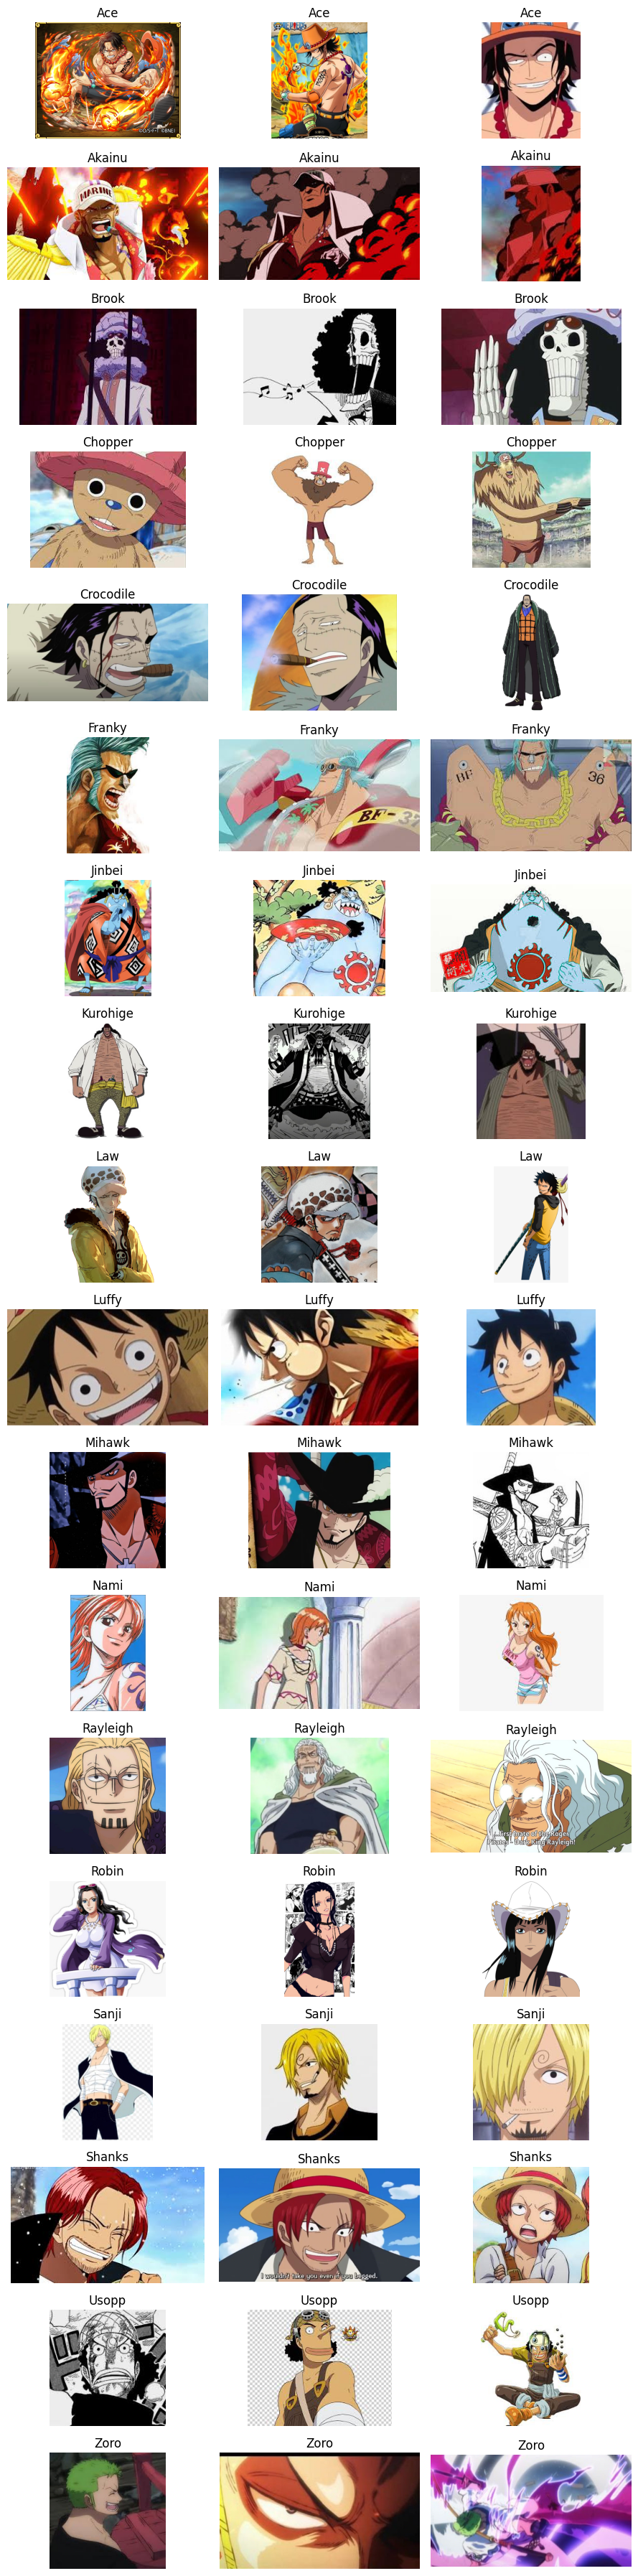

In [8]:
N_SHOW = 3
IMAGE_EXTENSIONS = ("png", "jpg", "jpeg", "bmp", "webp")

fig, axes = plt.subplots(len(labels), N_SHOW, figsize=(N_SHOW * 3, len(labels) * 2))
axes = axes.flatten()

i_ax = 0
for idx, (label_idx, cls) in enumerate(labels.items()):
    img_dir = os.path.join(DATA_DIR, 'train', cls)
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)]

    for j in range(N_SHOW):
        if j < len(img_files):
            img_fp = os.path.join(img_dir, img_files[j])
            img = Image.open(img_fp).convert("RGB")
            axes[i_ax].imshow(img)
            axes[i_ax].set_title(f"{cls}")
            axes[i_ax].axis('off')
            i_ax += 1
        else:
            axes[i_ax].axis('off')
            i_ax += 1

plt.tight_layout()
plt.show()


Изображения имеют разные форматы, размеры, что-то взято из оригинального аниме, а что-то из манги/артов/визуализаций и пр.

## Препроцессинг

На этапе препроцессинга мы сначала приводим все изображения к одному размеру `224×224`. Затем открываем каждую картинку в режиме `RGB` - для избавления от ошибок совместимости при обучении

Далее применяем лёгкие аугментации: случайный горизонтальный флип, изменения яркости и контраста и т. д. Это помогает расширить набор примеров без реального увеличения датасета и делает модель устойчивее. После этого нормализуем изображение под статистики `ImageNet`, чтобы предобученные модели работали корректно и сходились быстрее. В конце данные разбиваем на `train/val` и загружаем через `DataLoader`, чтобы обучение шло батчами и без лишних задержек



In [9]:
IMG_SIZE = 224

class OnePieceDataset(Dataset):
    """
    Кастомный PyTorch Dataset для классификации персонажей One Piece.

    Поддерживает train/val/test режимы, аугментации через transforms или albumentations,
    а также обработку ошибок чтения файлов (например, битые изображения).
    """
    def __init__(self, annotations: pd.DataFrame, img_root: str, mode: str = 'train',
                 transform: Optional[Callable] = None):
        self.ann = annotations.reset_index(drop=True)
        self.img_root = img_root
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        rec = self.ann.iloc[idx]
        img_path = os.path.join(self.img_root, rec['image_path'].replace('\\', os.sep).replace('/', os.sep))
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Если не удается открыть изображение — заменим на случайное из того же класса
            print(f"Ошибка чтения {img_path}, {e}. Подставляется другой пример...")
            fallback_idx = self.ann[self.ann['class']==rec['class']].sample(1).index[0]
            return self.__getitem__(fallback_idx)
        if self.transform:
            image = self.transform(image)
        if self.mode == 'test':
            # В тесте метка может отсутствовать
            return image, rec['id']
        return image, rec['label']

In [10]:
# Пример базовых трансформаций (аугментаций) для train и val:
basic_train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
basic_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [11]:
# Пример разделения train/val
train_df, val_df = train_test_split(ann, test_size=0.1, random_state=42, stratify=ann['label'])

In [12]:
# Создаем датасеты и загрузчики
train_ds = OnePieceDataset(train_df, img_root=DATA_DIR, mode='train', transform=basic_train_transform)
val_ds = OnePieceDataset(val_df, img_root=DATA_DIR, mode='val', transform=basic_val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
# Пример вывода формы батча и базовой валидации пайплайна
data_iter = iter(train_loader)
batch_img, batch_lbl = next(data_iter)
print(f"Train image batch shape: {batch_img.shape}, labels: {batch_lbl[:5]}")

Train image batch shape: torch.Size([32, 3, 224, 224]), labels: tensor([ 4, 10,  8, 14,  2])


## MobileNetV3

**MobileNetV3 Small** — это лёгкая и быстрая нейросеть. Она использует сверточные блоки с глубинной свёрткой и механизмом SE-аттеншена, что делает её одновременно компактной и достаточно точной. Модель имеет всего ~2–3 млн параметров, поэтому обучается быстрее и требует меньше памяти, чем крупные архитектуры вроде ResNet или EfficientNet

Мы используем предобученную версию MobileNetV3 на ImageNet, потому что такая модель уже “знает” базовые визуальные признаки (углы, текстуры, формы) и её нужно только дообучить под наши 18 классов — это ускоряет обучение и повышает качество на небольшом датасете. В классификационной голове мы заменяем последний слой на наш `Linear(..., num_classes)` и запускаем стандартный цикл обучения: train/val проходы, оптимизация по CrossEntropyLoss, ранняя остановка и сохранение лучшей модели по F1-метрике




In [14]:
mobilenet_model = models.mobilenet_v3_small(weights='DEFAULT')
# replace head
mobilenet_model.classifier[3] = nn.Linear(mobilenet_model.classifier[3].in_features, len(labels))
print(f"MobileNetV3 (pretrained) params: {sum(p.numel() for p in mobilenet_model.parameters())//1_000}K")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 45.9MB/s]


MobileNetV3 (pretrained) params: 1536K


In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.
    true_labels = []
    pred_labels = []

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(preds.argmax(1).cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    f1 = f1_score(true_labels, pred_labels, average='macro')

    return avg_loss, f1

In [16]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            running_loss += loss.item()*x.size(0)
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(preds.argmax(1).cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    f1 = f1_score(true_labels, pred_labels, average='macro')

    return avg_loss, f1

In [17]:
def run_training(
    model, train_loader, val_loader, device,
    epochs=10, lr=1e-3,
    save_path='best_model.pth',
    weight_decay=1e-4, patience=4, verbose=1
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0; best_state = None; patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}

    for e in range(epochs):
        tr_loss, tr_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)
        history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
        history['train_f1'].append(tr_f1); history['val_f1'].append(val_f1)

        if verbose:
            print(f"Ep {e+1:2d} | Train: loss={tr_loss:.4f} f1={tr_f1:.4f} | Val: loss={val_loss:.4f} f1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1, best_state = val_f1, copy.deepcopy(model.state_dict())
            torch.save(best_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping — patience limit reached.")
                break

    model.load_state_dict(torch.load(save_path))
    return model, history

In [19]:
# MobileNetV3 (предобученная)
mobilenet_model, history_mobile = run_training(
    mobilenet_model, train_loader, val_loader, device=device, epochs=30, lr=1e-3, save_path='tl_best.pth'
)

Ep  1 | Train: loss=1.3724 f1=0.5854 | Val: loss=1.6187 f1=0.5781


Ep  2 | Train: loss=0.4533 f1=0.8594 | Val: loss=1.0069 f1=0.7373


Ep  3 | Train: loss=0.2671 f1=0.9140 | Val: loss=0.5302 f1=0.8416


Ep  4 | Train: loss=0.1762 f1=0.9450 | Val: loss=0.8016 f1=0.7918


Ep  5 | Train: loss=0.1134 f1=0.9652 | Val: loss=0.5628 f1=0.8698


Ep  6 | Train: loss=0.1138 f1=0.9625 | Val: loss=0.8140 f1=0.7907


Ep  7 | Train: loss=0.1089 f1=0.9637 | Val: loss=0.5990 f1=0.8369


Ep  8 | Train: loss=0.0812 f1=0.9711 | Val: loss=1.0598 f1=0.7683


Ep  9 | Train: loss=0.1283 f1=0.9610 | Val: loss=0.8849 f1=0.7805
Early stopping — patience limit reached.


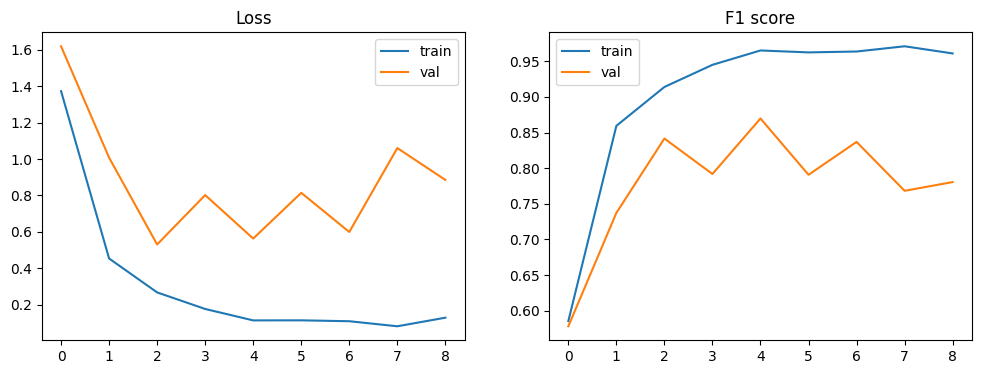

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_mobile['train_loss'], label='train'), plt.plot(history_mobile['val_loss'], label='val')
plt.title('Loss'), plt.legend()
plt.subplot(1,2,2)
plt.plot(history_mobile['train_f1'], label='train'), plt.plot(history_mobile['val_f1'], label='val')
plt.title('F1 score'), plt.legend(); plt.show()

Модель быстро обучается и достигает высокой точности на train, но метрика на val начинает колебаться и не улучшается после нескольких эпох, из-за чего сработала ранняя остановка

## Профилирование, Квантование и Инференс



In [21]:
def get_model_size(model):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        torch.save(model.state_dict(), f)
        size_mb = os.path.getsize(f.name)/1e6
    os.unlink(f.name)
    return size_mb

In [22]:
def inference_speed(model, loader, device, n_batches=5):
    model = model.to(device)
    model.eval()
    t_start = time.time()

    with torch.no_grad():
        nb = 0
        for x, _ in loader:
            x = x.to(device)
            _ = model(x)
            nb += 1
            if nb >= n_batches:
                break

    t_end = time.time()
    print(f"{model.__class__.__name__} ({device}) {n_batches} batches: {t_end-t_start:.2f} сек; BS={x.shape[0]}, среднее: {(t_end-t_start)/(n_batches*x.shape[0]):.4f} сек/образец")

In [23]:
print(f'MobileNetV3 size: {get_model_size(mobilenet_model):.2f} MB')
inference_speed(mobilenet_model, val_loader, device=device, n_batches=5)

MobileNetV3 size: 6.28 MB
MobileNetV3 (cpu) 5 batches: 4.71 сек; BS=32, среднее: 0.0294 сек/образец


In [24]:
# Для MobileNet применим dynamic quantization (линейные слои)
mobile_quantized = torch.quantization.quantize_dynamic(
    mobilenet_model, {nn.Linear}, dtype=torch.qint8
)
print(f'Квантованная MobileNetV3: {get_model_size(mobile_quantized):.2f} MB')

Квантованная MobileNetV3: 4.45 MB


Квантованная модель укладывается в лимит < 5MB

In [25]:
def collect_test_df():
    test_dir = os.path.join(DATA_DIR, 'test')
    img_files = glob.glob(os.path.join(test_dir, '*'))
    # Получим id из имени файла (оно в submission.csv)
    df = pd.DataFrame({'image_path': ['test'+os.sep+os.path.basename(f) for f in img_files]})
    df['id'] = df['image_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    return df

In [26]:
# Соберём DataFrame для теста и применим базовые трансформации
test_ann = ann[ann['split']=='test'] if 'test' in ann['split'].unique() else None

if test_ann is not None and len(test_ann)>0:
    test_df = test_ann.copy()
else:
    test_df = collect_test_df()

# Тестовый Dataset/DataLoader
test_ds = OnePieceDataset(test_df, img_root=DATA_DIR, mode='test', transform=basic_val_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [27]:
def predict_to_submission(model, test_loader, out_csv, device):
    model.eval()
    preds, ids = [], []

    with torch.no_grad():
        for x, img_ids in tqdm(test_loader):
            x = x.to(device)
            outputs = model(x)
            pred_labels = outputs.argmax(1).cpu().numpy()
            preds.extend(pred_labels)
            ids.extend(img_ids)

    sub = pd.DataFrame({'id': ids, 'label': preds})
    sub.to_csv(out_csv, index=False)
    print(f'Saved: {out_csv}')

In [29]:
# submission.csv с MobileNetV3
predict_to_submission(mobilenet_model, test_loader, out_csv='submission_mnv3.csv', device=device)

100%|██████████| 27/27 [00:14<00:00,  1.84it/s]

Saved: submission_mnv3.csv


In [30]:
# submission_quant.csv с квантованной моделбю
predict_to_submission(mobile_quantized, test_loader, out_csv='submission_mnv3_quant.csv', device=device)

100%|██████████| 27/27 [00:14<00:00,  1.83it/s]

Saved: submission_mnv3_quant.csv
